## Check some statistics for issues

In [4]:
import pandas as pd
import ray
import dask.dataframe as dd
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import json

In [ ]:
import dask
dask.config.set({'logging.distributed': 'error'})
import logging


In [1]:
set([1, 3, 5]).intersection(set([3, 10, 12]))

{3}

In [65]:
from toolkit_run.ray.server import LabRayToolkitServer
server = LabRayToolkitServer()
server.dashboard_url

2022-11-08 08:19:55,693	INFO worker.py:956 -- Connecting to existing Ray cluster at address: 10.210.122.222:8786
2022-11-08 08:19:55,696	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


'https://d836708a-223a-443a-be5c-78c61f5498a5-8000.job.console.elementai.com'

In [66]:
server.scale_cluster(60)

'OK'

In [144]:
ray.shutdown()

In [2]:
dst_path = Path('/dataset/gharchive_issues_permissive_repos_v2alfa2_py')

In [25]:
from toolkit_run.util.io import pickle_load
permissive_repos_py  = pickle_load(Path('/repo_workdir/permissive_repos_v2alfa2_py.pkl'))

In [26]:
permissive_repos_py_ref = ray.put(permissive_repos_py)

In [5]:
len(permissive_repos_py)

3718573

In [67]:
issue_files =  list(Path('/repo_workdir/gharchives_2015_issues/results/').glob('data-*.parquet'))

In [5]:
path = Path('/dataset/gharchives_2015')
files = list(path.glob('*'))

In [8]:
import gzip
def enum_jsongz_lines(file):
    with gzip.open(file, "r") as f:
        for line in f:
            try:
                yield json.loads(line)
            except Exception:
                continue

In [11]:

event_types = set(['IssuesEvent', 'IssueCommentEvent'])
events = []
to_break = False
for file in tqdm(files[0:]):
    for line in enum_jsongz_lines(file):
        try:
            event_type = line['type']
            if event_type in event_types:
                if 'pull_request' in line['payload']['issue'] and 'url' in line['payload']['issue']['pull_request']:
                    split = line['payload']['issue']['pull_request']['url'].split('/')
                    event_pull_request_data = {
                        'pull_request_user_login': split[4],
                        'pull_request_repo': split[5],
                        'pull_request_number': split[7]
                    }
                    try:
                        int(event_pull_request_data['pull_request_number'])
                    except ValueError as verr:
                        to_break = True
                        break
        except Exception:
            print(line)
            raise
    if to_break:
        break

  0%|          | 0/63209 [00:00<?, ?it/s]

In [13]:
split = line['payload']['issue']['pull_request']['url'].split('/')
event_pull_request_data = {
    'pull_request_user_login': split[-4],
    'pull_request_repo': split[-3],
    'pull_request_number': split[-1]
}

In [14]:
event_pull_request_data

{'pull_request_user_login': 'tierninho-acme-admin',
 'pull_request_repo': 'test',
 'pull_request_number': '7'}

In [15]:
line

{'id': '3492984190',
 'type': 'IssueCommentEvent',
 'actor': {'id': 15875616,
  'login': 'tierninho-acme-admin',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/tierninho-acme-admin',
  'avatar_url': 'https://avatars.githubusercontent.com/u/15875616?'},
 'repo': {'id': 46437212,
  'name': 'tierninho-acme-admin/test',
  'url': 'https://api.github.com/repos/tierninho-acme-admin/test'},
 'payload': {'action': 'created',
  'issue': {'url': 'https://garage.github.com/api/v3/repos/tierninho-acme-admin/test/issues/7',
   'labels_url': 'https://garage.github.com/api/v3/repos/tierninho-acme-admin/test/issues/7/labels{/name}',
   'comments_url': 'https://garage.github.com/api/v3/repos/tierninho-acme-admin/test/issues/7/comments',
   'events_url': 'https://garage.github.com/api/v3/repos/tierninho-acme-admin/test/issues/7/events',
   'html_url': 'https://github.com/tierninho-acme-admin/test/pull/7',
   'id': 124858004,
   'number': 7,
   'title': 'Revert "fghfghfg123"',
   'user': {'lo

## count number of issues

In [123]:
@ray.remote(num_cpus=2)
def process(file):
    df = pd.read_parquet(file)
    df = df[['event_created_at', 'event_repo_name', 'issue_number', 'issue_created_at']]
    df['issue_created_at'] = pd.to_datetime(df['issue_created_at'], errors='coerce')
    df['event_created_at'] = pd.to_datetime(df['event_created_at'], errors='coerce')
    groups = df.groupby(['event_repo_name', 'issue_number'])
    df1 = groups['issue_created_at'].first().to_frame()
    df1['issue_events_count'] = groups['event_created_at'].count()
    df1['event_min_datetime'] =  groups['event_created_at'].min()
    df1['event_max_datetime'] =  groups['event_created_at'].max()
    return df1
    

In [124]:
res = []
for file in issue_files:
    res.append(process.remote(file))
res = ray.get(res)

In [125]:
df = pd.concat(res)

In [128]:
df = df.reset_index(drop=False)

In [130]:
groups = df.groupby('event_repo_name')

In [129]:
df1 = pd.DataFrame()

In [131]:
df1['count'] = groups['issue_number'].count()

In [133]:
df1['event_min_datetime'] =  groups['event_min_datetime'].min()
df1['event_max_datetime'] =  groups['event_max_datetime'].max()

In [136]:
df1['issue_created_min_datetime'] =  groups['issue_created_at'].min()
df1['issue_created_max_datetime'] =  groups['issue_created_at'].max()

In [139]:
df1.sort_values('count')

,count,event_min_datetime,event_max_datetime,issue_created_min_datetime,issue_created_max_datetime
event_repo_name,,,,,
0----0/Terra-3d-Experiments,1,2018-12-20 23:10:13+00:00,2018-12-20 23:10:13+00:00,2018-12-20 23:10:13+00:00,2018-12-20 23:10:13+00:00
gpfla201/cdt,1,2019-05-18 17:57:41+00:00,2019-05-18 17:57:41+00:00,2019-05-18 17:57:41+00:00,2019-05-18 17:57:41+00:00
gpfjeff/cryptnos-for-windows,1,2016-06-14 03:39:30+00:00,2016-06-20 19:55:23+00:00,2016-06-14 03:39:29+00:00,2016-06-14 03:39:29+00:00
gpfister/gp-firebase-emulator-unit-test,1,2021-12-28 17:21:39+00:00,2021-12-28 17:21:39+00:00,2021-12-28 17:21:38+00:00,2021-12-28 17:21:38+00:00
gpfinley/amicus,1,2018-11-10 21:53:30+00:00,2018-11-10 21:53:30+00:00,2018-11-10 21:53:30+00:00,2018-11-10 21:53:30+00:00
...,...,...,...,...,...
PlaNFT/PlaNFT-Marketplace-Comments,169481,2022-01-06 11:26:08+00:00,2022-03-31 23:45:36+00:00,2022-01-06 11:26:07+00:00,2022-03-31 23:45:36+00:00
lstjsuperman/fabric,173979,2017-07-11 02:30:00+00:00,2021-03-19 21:00:38+00:00,2017-07-11 02:30:00+00:00,2020-05-05 14:03:38+00:00
koorellasuresh/UKRegionTest,379339,2017-06-25 01:28:21+00:00,2019-10-11 00:20:04+00:00,2017-06-25 01:28:21+00:00,2019-10-11 00:20:04+00:00


/tmp/ipykernel_441/2572184760.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


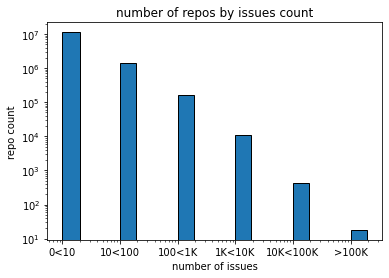

In [142]:
import numpy as np
import matplotlib.pyplot as plt
hist, bins = np.histogram(df1['count'], bins=[0, 10, 100, 1000, 10000, 100000, 1000000])
fig, ax = plt.subplots()
ax.bar(bins[1:], hist, width=np.diff(bins), log=True,ec="k", align="edge")
ax.set_xscale("log")
ax.set_title('number of repos by issues count')
ax.set_xlabel('number of issues')
ax.set_ylabel('repo count')

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = '0<10'
labels[3] = '10<100'
labels[4] = '100<1K'
labels[5] = '1K<10K'
labels[6] = '10K<100K'
labels[7] = '>100K'

ax.set_xticklabels(labels)

plt.show()

In [143]:
df1.to_parquet('/repo_workdir/issues_per_repos_all.parquet')

In [80]:
grouped = df.groupby('repo_name')

,event_repo_name,issue_number,issue_created_at
9622,eclipse-ee4j/glassfish-woodstock,615,1969-12-31 16:00:00+00:00
9487,Perl/perl5,94,1999-06-22 19:10:20+00:00
8651,Perl/perl5,335,1999-08-03 16:41:07+00:00
826,Perl/perl5,339,1999-08-04 18:59:23+00:00
1521,Perl/perl5,799,1999-10-29 11:38:24+00:00
...,...,...,...
12093,shaposhnikoff/arduino-wemos-esp8266,113,2031-03-11 17:00:40+00:00
1886,shaposhnikoff/arduino-wemos-esp8266,127,2031-03-11 17:00:40+00:00
4412,Zimmi48/test-issue-import-api,9,2100-03-01 12:00:00+00:00
2719,shaposhnikoff/arduino-wemos-esp8266,140,NaT


## end count number of issues

In [68]:
df = pd.read_parquet(issue_files[3])

In [101]:
df = pd.read_parquet('/repo_workdir/gharchives_2015_issues/results/data-613.parquet')

In [61]:
df.columns

Index(['hexsha_issue_id', 'event_type', 'event_id', 'event_actor_name',
       'event_actor_id', 'event_is_public', 'event_created_at',
       'event_repo_id', 'event_repo_name', 'event_org_id', 'event_org_login',
       'event_action', 'issue_id', 'issue_number', 'issue_title',
       'issue_user_name', 'issue_user_id', 'issue_labels', 'issue_status',
       'issue_is_locked', 'issue_comments', 'issue_created_at',
       'issue_updated_at', 'issue_closed_at', 'issue_body',
       'issue_assignee_name', 'issue_assignee_id', 'milestone_id',
       'milestone_number', 'milestone_title', 'milestone_description',
       'milestone_actor_name', 'milestone_actor_id', 'milestone_open_issues',
       'milestone_closed_issues', 'milestone_state', 'milestone_created_at',
       'milestone_updated_at', 'milestone_due_on', 'milestone_closed_at',
       'milestone_creator_name', 'milestone_creator_id',
       'pull_request_user_login', 'pull_request_repo', 'pull_request_number',
       'comment_id'

In [103]:
df = df.drop_duplicates('event_id')
df = df[['event_id', 'event_created_at', 'event_repo_name', 'issue_number', 'issue_created_at']]

In [104]:
df['issue_created_at'] = pd.to_datetime(df['issue_created_at'], errors='coerce')
df['event_created_at'] = pd.to_datetime(df['event_created_at'], errors='coerce')

,event_id,event_created_at,event_repo_name,issue_number,issue_created_at
2274,2861384669,2015-06-03 20:25:49+00:00,whomwah/rqrcode,3,2010-11-18 17:18:50+00:00
2275,2861384674,2015-06-03 20:25:49+00:00,whomwah/rqrcode,3,2010-11-18 17:18:50+00:00
1284,3488601332,2016-01-03 03:46:47+00:00,fribeiro1/FileReaderService,4,2011-06-05 19:03:06+00:00
2627,4244059578,2016-07-07 02:50:25+00:00,jseutter/ofxparse,12,2011-06-24 18:54:12+00:00
1370,4812382871,2016-11-03 17:09:32+00:00,ipython/ipython,652,2011-08-01 11:27:59+00:00
...,...,...,...,...,...
10800,21053302140,2022-03-31 22:49:36+00:00,shanf-gh/github-slideshow,1,2022-03-31 22:49:34+00:00
265,21053460886,2022-03-31 23:01:34+00:00,shanf-gh/github-slideshow,1,2022-03-31 22:49:34+00:00
867,21053501541,2022-03-31 23:04:44+00:00,shanf-gh/github-slideshow,1,2022-03-31 22:49:34+00:00
958,21053508540,2022-03-31 23:05:19+00:00,shanf-gh/github-slideshow,1,2022-03-31 22:49:34+00:00


In [106]:
groups = df.groupby(['event_repo_name', 'issue_number'])

In [111]:

for i, gr in enumerate(groups):
    if len(gr[1]) > 5:
        break

In [115]:
print(gr[1]['event_created_at'].min())
print(gr[1]['event_created_at'].max())

2015-01-26 00:56:40+00:00
2015-02-02 03:58:00+00:00


In [119]:
df1 = groups['issue_created_at'].first().to_frame()
df1['issue_events_count'] = groups['event_created_at'].count()

In [120]:
df1['event_min_datetime'] =  groups['event_created_at'].min()
df1['event_max_datetime'] =  groups['event_created_at'].max()

In [122]:
df1[df1['issue_events_count'] > 1]

issue_created_at  \
event_repo_name                    issue_number                             
01org/TPM2.0-TSS                   237          2016-07-13 02:44:15+00:00   
01org/tpm2.0-tools                 146          2017-01-12 00:01:24+00:00   
                                   150          2017-01-12 00:07:22+00:00   
03-cs-wockys-waywards/capstone     74           2021-07-13 03:56:11+00:00   
06000208/sandplate                 3            2020-06-16 10:38:23+00:00   
...                                                                   ...   
zxombie/libtrue                    43           2017-06-10 03:32:04+00:00   
zxtion/danger-chasers              5            2021-07-25 03:57:46+00:00   
zyumingfit/TRC20-Contract-Template 8            2020-09-16 05:40:49+00:00   
zzak/sdoc                          80           2014-11-05 17:07:37+00:00   
zzhichen/codeql-uboot              5            2021-11-20 06:14:29+00:00   

                                                 issue_events_count  \
event_repo_name                    issue_number                       
01org/TPM2.0-TSS                   237                            3   
01org/tpm2.0-tools                 146                            3   
                                   150                            3   
03-cs-wockys-waywards/capstone     74                             4   
06000208/sandplate                 3                              3   
...                                                             ...   
zxombie/libtrue                    43                             3   
zxtion/danger-chasers              5                              2   
zyumingfit/TRC20-Contract-Template 8                              2   
zzak/sdoc                          80                             3   
zzhichen/codeql-uboot              5                              5   

                                                       event_min_datetime  \
event_repo_name                    issue_number                             
01org/TPM2.0-TSS                   237          2016-07-13 02:44:15+00:00   
01org/tpm2.0-tools                 146          2017-01-12 00:01:24+00:00   
                                   150          2017-01-12 00:07:22+00:00   
03-cs-wockys-waywards/capstone     74           2021-07-13 03:56:11+00:00   
06000208/sandplate                 3            2020-06-16 10:38:24+00:00   
...                                                                   ...   
zxombie/libtrue                    43           2017-06-10 03:32:04+00:00   
zxtion/danger-chasers              5            2021-07-25 03:57:46+00:00   
zyumingfit/TRC20-Contract-Template 8            2020-09-16 05:40:49+00:00   
zzak/sdoc                          80           2016-03-14 09:56:25+00:00   
zzhichen/codeql-uboot              5            2021-11-20 06:14:29+00:00   

                                                       event_max_datetime  
event_repo_name                    issue_number                            
01org/TPM2.0-TSS                   237          2017-02-21 21:31:53+00:00  
01org/tpm2.0-tools                 146          2017-01-23 02:06:04+00:00  
                                   150          2017-02-02 16:55:03+00:00  
03-cs-wockys-waywards/capstone     74           2021-07-15 15:46:45+00:00  
06000208/sandplate                 3            2020-06-16 18:15:47+00:00  
...                                                                   ...  
zxombie/libtrue                    43           2017-06-10 03:36:34+00:00  
zxtion/danger-chasers              5            2021-07-25 06:47:42+00:00  
zyumingfit/TRC20-Contract-Template 8            2021-09-04 19:11:09+00:00  
zzak/sdoc                          80           2016-07-14 05:59:41+00:00  
zzhichen/codeql-uboot              5            2021-11-20 10:53:32+00:00  

[18699 rows x 4 columns]

## Combine issues to a flow

In [33]:
df['event_created_at'] = pd.to_datetime(df['event_created_at'])
df = df.sort_values('event_created_at')

In [7]:
df = df.groupby('issue_id').filter(lambda x: len(x) > 20)
#df = df.groupby('comment_id').filter(lambda x: len(x) > 2)

In [ ]:
for file in tqdm(issue_files[1230:]):
    df = pd.read_parquet(file)
    df['event_created_at'] = pd.to_datetime(df['event_created_at'])
    #df = df.sort_values('event_created_at')
    df = df[df['event_action'] == 'edited']
    if len(df) > 0:
        break

  0%|          | 0/2866 [00:00<?, ?it/s]

In [45]:
# drop duplicates by event id

Index(['hexsha_issue_id', 'event_type', 'event_id', 'event_actor_name',
       'event_actor_id', 'event_is_public', 'event_created_at',
       'event_repo_id', 'event_repo_name', 'event_org_id', 'event_org_login',
       'event_action', 'issue_id', 'issue_number', 'issue_title',
       'issue_user_name', 'issue_user_id', 'issue_labels', 'issue_status',
       'issue_is_locked', 'issue_comments', 'issue_created_at',
       'issue_updated_at', 'issue_closed_at', 'issue_body',
       'issue_assignee_name', 'issue_assignee_id', 'milestone_id',
       'milestone_number', 'milestone_title', 'milestone_description',
       'milestone_actor_name', 'milestone_actor_id', 'milestone_open_issues',
       'milestone_closed_issues', 'milestone_state', 'milestone_created_at',
       'milestone_updated_at', 'milestone_due_on', 'milestone_closed_at',
       'milestone_creator_name', 'milestone_creator_id',
       'pull_request_user_login', 'pull_request_repo', 'pull_request_number',
       'comment_id'

In [8]:
iii = 0
for gr in df.groupby('issue_id'):
    if iii >= 0:
        break
    iii += 1

In [38]:
def parse_comment(r):
    # actions: created, edited or deleted
    comment = {
        'type': 'comment',
        'action': r['event_action'],
        'datetime': str(r['event_created_at']),
        'author': r['event_actor_name'],
        'comment_id': int(r['comment_id']),
    }
    if r['event_action'] != 'deleted':
        comment['comment'] = r['comment_body']
    return comment

def parse_issue(r, force_open=False):

    if force_open:
        # if issue was from before 2015 or because of gharchive outage
        # it will not have open event, so we emulate it
        issue =  {
            'type': 'issue',
            'action': 'opened',
            'datetime': str(r['issue_created_at']),
            'author': r['issue_user_name'],
            'title': r['issue_title'],
            'description': r['issue_body']
        }
    else:
        issue = {
            'type': 'issue',
            'action': r['event_action'],
            'datetime': str(r['event_created_at']),
            'author': r['event_actor_name'],
        }
        if r['event_action'] == 'opened' or r['event_action'] == 'edited' or r['event_action'] == 'reopened':
            # all those events can result in different title or description
            issue.update({
                'title': r['issue_title'],
                'description': r['issue_body']
            })

        if r['event_action'] == 'closed':
            # no additional info
            pass

        if r['event_action'] == 'assigned' or r['event_action'] == 'unassigned':
            issue.update({
                'assignee': r['issue_assignee_name'],
            })

        if r['event_action'] == 'labeled' or r['event_action'] == 'unlabeled':
            issue.update({
                'labels': list(r['issue_labels']) if isinstance(r['issue_labels'], np.ndarray) else r['issue_labels'],
            })

    return issue

def parse_issue_history(gr):
    gr = gr[1]
    res_dict = {}
    indx = 0
    r = gr.iloc[0]
    res_dict['repo'] = r['event_repo_name']
    res_dict['org'] = r['event_org_login']
    res_dict['issue_id'] = int(r['issue_id'])
    res_dict['issue_number'] = int(r['issue_number'])

    # From docs: all PR are issues but not all issues are PR, for PR review comments use PR api (which is not done yet)
    # supposedly if we have PR not None it is a general discussion of some PR, so we just mark issue's PR for now
    if r['pull_request_user_login'] is not None:
        res_dict['pull_request'] = {
            'user_login': r['pull_request_user_login'],
            'repo': r['pull_request_repo'],
            'number': int(r['pull_request_number'])
        }
    else:
        res_dict['pull_request'] = None

    res_dict['events'] = []

    for i, r in gr.iterrows():
        if indx == 0:
            if r['event_type'] != 'IssuesEvent' or r['event_action'] != 'opened':
                res_dict['events'].append(parse_issue(r, force_open=True))

        # TODO: edited events will need to be later aggregated with their open or reopen events
        #       however, for some reason no single edited event in the set, check original parser
        if r['event_type'] == 'IssueCommentEvent':
            res_dict['events'].append(parse_comment(r))
        elif r['event_type'] == 'IssuesEvent':
            res_dict['events'].append(parse_issue(r))
        else:
            raise RuntimeError(f"unexpeceted event type: {r['event_type']}")
        indx += 1

    return res_dict

def process_bucket(file, good_repos):
    df = pd.read_parquet(file)
    df = df[df['event_repo_name'].isin(good_repos)]
    df['event_created_at'] = pd.to_datetime(df['event_created_at'])
    df = df.sort_values('event_created_at')
    res = []
    for gr in df.groupby('issue_id'):
        res.append(parse_issue_history(gr))
    return res

def print_issue_history(data, truncate=False):
    res = ''
    res += f"REPO: {data['repo']}\n"
    if data['org'] is not None:
        res += f"ORG: {data['org']}\n"
    res += f"ISSUE NUNBER: {int(data['issue_number'])}\n"
    
    if data['pull_request'] is not None:
        res += f"PULL REQUEST [USER: {data['pull_request']['user_login']} REPO: {data['pull_request']['repo']} NUMBER: {data['pull_request']['number']}]\n"
    res += '\n\n'
    
    for event in data['events']:
        if event['type'] == 'comment':
            res += f"COMMENT {int(event['comment_id'])} {event['action'].upper()} [{event['datetime']}] BY {event['author']}\n"
            if event['action'] != 'deleted':
                if truncate:
                    res += event['comment'][:100] + '...\n'
                else:
                    res += event['comment'] + '\n'
            res +=  '\n'
        elif event['type'] == 'issue':
            res += f"ISSUE {event['action'].upper()} [{event['datetime']}] BY {event['author']}\n"
            if event['action'] == 'edited' or event['action'] == 'opened' or event['action'] == 'reopened':
                res += f"TITLE: {event['title']}\n"
                if truncate:
                    res += f"DESCRIPTION: {event['description'][:100]}...\n"
                else:
                    res += f"DESCRIPTION: {event['description']}\n"
            elif event['action'] == 'assigned' or event['action'] == 'unassigned':
                res += f"{event['assignee']}\n"
            elif event['action'] == 'labeled' or event['action'] == 'unlabeled':
                res += f"{event['labels']}\n"
            else:
                pass
            res += '\n'
        else:
            pass

    return res



    


In [45]:
def process(file, good_repos, dst_path):
    try:
        data = process_bucket(file, good_repos)
        dst_file = dst_path / (file.stem+'.jsonl')
        with dst_file.open('wt') as f:
            for el in data:
                f.write(json.dumps(el)+'\n')
    except Exception as e:
        print(e)
        return 0, file
    return len(data), None

In [46]:
@ray.remote(num_cpus=2)
def process_ray(file, good_repos, dst_path):
    return process(file, good_repos, dst_path)

In [47]:
res = []
for file in [
    Path('/repo_workdir/gharchives_2015_issues/results/data-613.parquet'),
    Path('/repo_workdir/gharchives_2015_issues/results/data-3488.parquet'),
    Path('/repo_workdir/gharchives_2015_issues/results/data-3381.parquet'),
    Path('/repo_workdir/gharchives_2015_issues/results/data-3236.parquet'),
]:
    res.append(process_ray.remote(file, permissive_repos_py_ref, dst_path))
res = ray.get(res)

In [48]:
for el in res:
    if el[1] is not None:
        print(el[1])

In [19]:
process(issue_files[0], permissive_repos_py, dst_path)

(4299, None)

In [52]:
data = process_bucket('/repo_workdir/gharchives_2015_issues/results/data-613.parquet', permissive_repos_py)

In [53]:
len(data)

4317

In [56]:
print(print_issue_history(data[199], truncate=True))

REPO: nodemcu/nodemcu-firmware
ISSUE NUNBER: 784


ISSUE OPENED [2015-11-21 13:54:49+00:00] BY confile
TITLE: Waiting answer from ESP - Timeout reached. Command aborted. on Dev Branch
DESCRIPTION: I use the latest Dev Branch commit: b216e6a809edd035d70536a691c4a07ac4b256a9

I build all modules ...

COMMENT 158649153 CREATED [2015-11-21 14:42:01+00:00] BY devsaurus
I can confirm such issues with ESPlorer at the moment. I'll investigate what's been broken....

COMMENT 158659518 CREATED [2015-11-21 16:17:00+00:00] BY steffimueller
+1 I have the same problem. Not working on dev branch...

COMMENT 158678773 CREATED [2015-11-21 20:22:20+00:00] BY devsaurus
Ok, checked the sources. ESPlorer seems to use CR&LF for most obvious things per default, but falls ...

COMMENT 158758409 CREATED [2015-11-22 12:59:24+00:00] BY devsaurus
@confile @steffimueller if possible, please check whether #786 improves things for your ESPlorer set...

COMMENT 158759195 CREATED [2015-11-22 13:22:15+00:00] BY eyaleb


In [43]:
for el in data:
    json.dumps(el)

In [51]:
el

(4419, None)

In [87]:
for el in data:
    print_issue_history(el)

In [28]:
gr[1][['event_type', 'event_created_at', 'event_action', 'issue_title', 'issue_body']]

,event_type,event_created_at,event_action,issue_title,issue_body
1388,IssuesEvent,2015-01-02 15:30:18+00:00,opened,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
1477,IssueCommentEvent,2015-01-02 15:32:06+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
1806,IssueCommentEvent,2015-01-02 15:38:47+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
2737,IssueCommentEvent,2015-01-02 15:53:51+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
64,IssueCommentEvent,2015-01-02 16:01:24+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
97,IssueCommentEvent,2015-01-02 16:02:05+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
231,IssueCommentEvent,2015-01-02 16:04:40+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
280,IssueCommentEvent,2015-01-02 16:05:28+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
347,IssueCommentEvent,2015-01-02 16:06:48+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...
836,IssueCommentEvent,2015-01-02 16:17:28+00:00,created,Wrong dependency version resolution,`paket.dependencies`:\r\n```\r\nsource https:/...


In [9]:
gr[1].columns

NameError: name 'gr' is not defined

In [ ]:
res_dict

In [ ]:
@ray.remote(num_cpus=4)
def process(file, permissive_repos):
    df = pd.read_parquet(file)
    df = df[df['event_repo_name'].isin(permissive_repos)]
    return df['comment_body'].dropna().apply(len).sum(), len(df)
    

In [ ]:
res = []
for file in tqdm(issue_files):
    res.append(process.remote(file, permissive_repos_ref))

In [ ]:
res = ray.get(res)

In [ ]:
res = list(zip(*res))

In [ ]:
sum(res[0]) / 1000000000

In [ ]:
sum(res[1]) /1000000


In [ ]:
ray.status()

In [ ]:
ddf = dd.read_parquet('/repo_workdir/gharchives_2015_issues/results/data-*.parquet')

In [ ]:
# Number of issues and issue comments
len(ddf)

In [ ]:
type(permissive_repos)

In [ ]:
# Number of characters in issue comments bodies
ddf[ddf['event_repo_name'].isin(permissive_repos)]['comment_body'].dropna().apply(len).sum().compute()

In [ ]:
# Number of issue comments as issues do not have commemt_body
ddf['comment_body'].dropna().count().compute()

In [ ]:
# Number of characters per issue comment
133687669245 / 278540300

In [ ]:
def apply_per_partition(df):
    df = df[(df['event_type'] == 'IssuesEvent') & (df['event_action'] == 'opened')]
    event_cnt = df['event_type'].count()
    body_len = df['issue_body'].dropna().apply(len).sum()
    title_len = df['issue_title'].dropna().apply(len).sum()
    return event_cnt, body_len, title_len

def apply_per_partition_fn(filename):
    df = pd.read_parquet(filename)
    return apply_per_partition(df)

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, silence_logs=logging.ERROR)
client = Client(cluster)

In [ ]:
files = list(Path('/repo_workdir/gharchives_2015_issues/results/').glob('data-*.parquet'))
cnt = 0
res_f = []
for file in tqdm(files):
    res_f.append(client.submit(apply_per_partition_fn, file))
   

In [ ]:
res = client.gather(res_f)

In [ ]:
event_cnt, body_len, title_len = zip(*res)
event_cnt = [v() for v in event_cnt]
print('event_cnt', sum(event_cnt))
print('body_len', sum(body_len))
print('title_len', sum(title_len))

In [ ]:
75848739906/1024/1024/1024

In [ ]:
2945768396/1024/1024/1024

In [ ]:
client.shutdown()
client.close()